# Stock Price Prediction of NLIC

## Import the Required Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from keras import Sequential
from keras.layers import GRU, LSTM, SimpleRNN,  Dense, Dropout
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

2022-07-30 05:03:22.853369: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-30 05:03:22.853401: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load Data

In [3]:
nlic_df = pd.read_csv("data/NLIC.csv")
nlic_df.shape

(2361, 8)

In [4]:
nlic_df.head()

,S.N.,Date,Total Transactions,Total Traded Shares,Total Traded Amount,Max. Price,Min. Price,Close Price
0,1,2021-12-29,617,34091.0,51845988.9,1550.0,1505.0,1510.0
1,2,2021-12-28,1009,64705.0,99059083.3,1570.0,1490.0,1535.0
2,3,2021-12-27,2842,156993.0,249797913.1,1652.0,1530.0,1540.0
3,4,2021-12-26,1765,125395.0,190751050.3,1533.4,1420.0,1533.0
4,5,2021-12-23,645,38404.0,53584721.2,1412.7,1375.0,1394.0


## Renaming the Columns 

In [5]:
nlic_df.columns = ['SN', 'Date', 'TTrans', 'TTS','TTA', 'MaxPrice', 'MinPrice', 'ClosePrice']

In [6]:
nlic_df.head()

,SN,Date,TTrans,TTS,TTA,MaxPrice,MinPrice,ClosePrice
0,1,2021-12-29,617,34091.0,51845988.9,1550.0,1505.0,1510.0
1,2,2021-12-28,1009,64705.0,99059083.3,1570.0,1490.0,1535.0
2,3,2021-12-27,2842,156993.0,249797913.1,1652.0,1530.0,1540.0
3,4,2021-12-26,1765,125395.0,190751050.3,1533.4,1420.0,1533.0
4,5,2021-12-23,645,38404.0,53584721.2,1412.7,1375.0,1394.0


In [7]:
nlic_df.shape

(2361, 8)

Converting the Date into Panda's Date Time 

In [9]:
nlic_df['Date'] = pd.to_datetime(nlic_df['Date'])

## Sorting the Date by Date in Ascending Order

In [13]:
nlic_df=nlic_df.sort_values(by='Date')

## Setting Features and Target Column

In [14]:
features = ['Date','ClosePrice']

In [15]:
X = nlic_df[features]

In [16]:
X.set_index("Date",inplace=True)

## Splitting the Data Into Training, Validation and Test Set

In [17]:
X_train_split, X_test_split = train_test_split(X, train_size=0.8,shuffle=False)
X_test_split, X_valid_split = train_test_split(X_test_split, train_size=0.5,shuffle=False)

## Fucntion to slice data to Predict next day’s closing price by looking into previous 5 day’s data

In [18]:
def SliceData(data,step):     
    X,Y = [],[]
    for i in range(len(data)-step):
        X.append(data[i:(i+step),])
        Y.append(data[(i+step),])
    return np.array(X),np.array(Y)

## Normalizing the Data Using Standard Scalar

In [19]:
std_scalar = StandardScaler()
X_train = std_scalar.fit_transform(X_train_split)
X_valid = std_scalar.fit_transform(X_valid_split)
X_test = std_scalar.fit_transform(X_test_split)

## Getting the Sliced Data

In [20]:
steps = 5
X_train,y_train = SliceData(X_train,steps)
X_test,y_test = SliceData(X_test,steps)
X_valid,y_valid = SliceData(X_valid,steps)

## Building the RNN Model

In [21]:
RNN_Model = Sequential()
RNN_Model.add(SimpleRNN(50,input_shape=(steps,1),return_sequences=True ))
RNN_Model.add(Dropout(0.5))
RNN_Model.add(SimpleRNN(50))
RNN_Model.add(Dropout(0.5))
RNN_Model.add(Dense(50))
RNN_Model.compile(optimizer='adam',loss='mean_squared_error', metrics=['mae'])

2022-07-30 05:03:47.508580: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-30 05:03:47.508629: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-30 05:03:47.508674: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xenon-Inspiron-3442): /proc/driver/nvidia/version does not exist
2022-07-30 05:03:47.509017: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
RNN_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5, 50)             2600      
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
Total params: 10,200
Trainable params: 10,200
Non-trainable params: 0
_________________________________________________________________


## Building LSTM Model

In [23]:
LSTM_Model = Sequential()
LSTM_Model.add(LSTM(50,input_shape=(steps,1),return_sequences=True ))
LSTM_Model.add(Dropout(0.5))
LSTM_Model.add(LSTM(50))
LSTM_Model.add(Dropout(0.5))
LSTM_Model.add(Dense(50))
LSTM_Model.compile(optimizer='adam',loss='mean_squared_error', metrics=['mae'])

In [24]:
LSTM_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 dropout_2 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
Total params: 33,150
Trainable params: 33,150
Non-trainable params: 0
_________________________________________________________________


## Fitting the RNN Model

In [25]:
RNN_History = RNN_Model.fit(X_train,y_train,epochs=100,batch_size = 50,validation_data=(X_valid,y_valid),shuffle=False, 
                    verbose = 2)

Epoch 1/100
38/38 - 2s - loss: 0.7605 - mae: 0.6460 - val_loss: 0.2494 - val_mae: 0.3208 - 2s/epoch - 60ms/step
Epoch 2/100
38/38 - 0s - loss: 0.3379 - mae: 0.4257 - val_loss: 0.1658 - val_mae: 0.2495 - 231ms/epoch - 6ms/step
Epoch 3/100
38/38 - 0s - loss: 0.2462 - mae: 0.3657 - val_loss: 0.1401 - val_mae: 0.2306 - 246ms/epoch - 6ms/step
Epoch 4/100
38/38 - 0s - loss: 0.1957 - mae: 0.3229 - val_loss: 0.1192 - val_mae: 0.2128 - 195ms/epoch - 5ms/step
Epoch 5/100
38/38 - 0s - loss: 0.1719 - mae: 0.3025 - val_loss: 0.1139 - val_mae: 0.2093 - 204ms/epoch - 5ms/step
Epoch 6/100
38/38 - 0s - loss: 0.1551 - mae: 0.2873 - val_loss: 0.1032 - val_mae: 0.1999 - 208ms/epoch - 5ms/step
Epoch 7/100
38/38 - 0s - loss: 0.1380 - mae: 0.2718 - val_loss: 0.1013 - val_mae: 0.2029 - 205ms/epoch - 5ms/step
Epoch 8/100
38/38 - 0s - loss: 0.1291 - mae: 0.2594 - val_loss: 0.0920 - val_mae: 0.1923 - 255ms/epoch - 7ms/step
Epoch 9/100
38/38 - 0s - loss: 0.1158 - mae: 0.2470 - val_loss: 0.0847 - val_mae: 0.1836 -

Epoch 73/100
38/38 - 0s - loss: 0.0559 - mae: 0.1630 - val_loss: 0.0588 - val_mae: 0.1573 - 273ms/epoch - 7ms/step
Epoch 74/100
38/38 - 0s - loss: 0.0483 - mae: 0.1542 - val_loss: 0.0494 - val_mae: 0.1423 - 195ms/epoch - 5ms/step
Epoch 75/100
38/38 - 0s - loss: 0.0524 - mae: 0.1617 - val_loss: 0.0549 - val_mae: 0.1483 - 178ms/epoch - 5ms/step
Epoch 76/100
38/38 - 0s - loss: 0.0486 - mae: 0.1555 - val_loss: 0.0488 - val_mae: 0.1393 - 206ms/epoch - 5ms/step
Epoch 77/100
38/38 - 0s - loss: 0.0511 - mae: 0.1597 - val_loss: 0.0527 - val_mae: 0.1458 - 178ms/epoch - 5ms/step
Epoch 78/100
38/38 - 0s - loss: 0.0541 - mae: 0.1638 - val_loss: 0.0454 - val_mae: 0.1345 - 186ms/epoch - 5ms/step
Epoch 79/100
38/38 - 0s - loss: 0.0508 - mae: 0.1552 - val_loss: 0.0516 - val_mae: 0.1464 - 207ms/epoch - 5ms/step
Epoch 80/100
38/38 - 0s - loss: 0.0507 - mae: 0.1537 - val_loss: 0.0558 - val_mae: 0.1493 - 292ms/epoch - 8ms/step
Epoch 81/100
38/38 - 0s - loss: 0.0484 - mae: 0.1536 - val_loss: 0.0465 - val_ma

In [26]:
LSTM_History = LSTM_Model.fit(X_train,y_train,epochs=100,batch_size = 50,validation_data=(X_valid,y_valid),shuffle=False, 
                    verbose = 2)

Epoch 1/100
38/38 - 6s - loss: 0.8425 - mae: 0.7812 - val_loss: 0.4477 - val_mae: 0.4636 - 6s/epoch - 158ms/step
Epoch 2/100
38/38 - 0s - loss: 0.2807 - mae: 0.3981 - val_loss: 0.1832 - val_mae: 0.2948 - 345ms/epoch - 9ms/step
Epoch 3/100
38/38 - 0s - loss: 0.1445 - mae: 0.2747 - val_loss: 0.1790 - val_mae: 0.2597 - 355ms/epoch - 9ms/step
Epoch 4/100
38/38 - 0s - loss: 0.1368 - mae: 0.2726 - val_loss: 0.1420 - val_mae: 0.2368 - 482ms/epoch - 13ms/step
Epoch 5/100
38/38 - 0s - loss: 0.1077 - mae: 0.2373 - val_loss: 0.1477 - val_mae: 0.2384 - 362ms/epoch - 10ms/step
Epoch 6/100
38/38 - 0s - loss: 0.1120 - mae: 0.2427 - val_loss: 0.1342 - val_mae: 0.2281 - 399ms/epoch - 10ms/step
Epoch 7/100
38/38 - 1s - loss: 0.0976 - mae: 0.2258 - val_loss: 0.1216 - val_mae: 0.2178 - 552ms/epoch - 15ms/step
Epoch 8/100
38/38 - 0s - loss: 0.0918 - mae: 0.2159 - val_loss: 0.1245 - val_mae: 0.2228 - 485ms/epoch - 13ms/step
Epoch 9/100
38/38 - 0s - loss: 0.0939 - mae: 0.2209 - val_loss: 0.1222 - val_mae: 0.

38/38 - 0s - loss: 0.0395 - mae: 0.1359 - val_loss: 0.0502 - val_mae: 0.1424 - 324ms/epoch - 9ms/step
Epoch 73/100
38/38 - 0s - loss: 0.0380 - mae: 0.1316 - val_loss: 0.0511 - val_mae: 0.1442 - 337ms/epoch - 9ms/step
Epoch 74/100
38/38 - 1s - loss: 0.0387 - mae: 0.1342 - val_loss: 0.0499 - val_mae: 0.1405 - 512ms/epoch - 13ms/step
Epoch 75/100
38/38 - 0s - loss: 0.0365 - mae: 0.1322 - val_loss: 0.0496 - val_mae: 0.1420 - 321ms/epoch - 8ms/step
Epoch 76/100
38/38 - 0s - loss: 0.0365 - mae: 0.1298 - val_loss: 0.0488 - val_mae: 0.1396 - 332ms/epoch - 9ms/step
Epoch 77/100
38/38 - 0s - loss: 0.0401 - mae: 0.1371 - val_loss: 0.0491 - val_mae: 0.1391 - 404ms/epoch - 11ms/step
Epoch 78/100
38/38 - 0s - loss: 0.0385 - mae: 0.1369 - val_loss: 0.0498 - val_mae: 0.1405 - 392ms/epoch - 10ms/step
Epoch 79/100
38/38 - 0s - loss: 0.0419 - mae: 0.1443 - val_loss: 0.0481 - val_mae: 0.1373 - 469ms/epoch - 12ms/step
Epoch 80/100
38/38 - 0s - loss: 0.0371 - mae: 0.1344 - val_loss: 0.0472 - val_mae: 0.1453

## Make Predictions

In [27]:
RNN_Predictions = RNN_Model.predict(X_test)
LSTM_predictions = LSTM_Model.predict(X_test)

## Inverse Transform the Values

In [28]:
RNN_act_prd = std_scalar.inverse_transform(RNN_Predictions)
LSTM_act_prd = std_scalar.inverse_transform(LSTM_predictions)

## Evalation Metrics (RMSE and MAE)

In [29]:
print("### RNN Model ###")
Y_test_res_RNN = std_scalar.inverse_transform(y_test)
pre_RNN = RNN_act_prd[:,:1]

rmse=np.sqrt(np.mean(((pre_RNN- Y_test_res_RNN)**2)))
print(f"RMSE {rmse}"  )

print(f"MAE {mean_absolute_error(Y_test_res_RNN, pre_RNN)}")

### RNN Model ###
RMSE 76.88429113784437
MAE 46.06268971100514


In [30]:
print("### LSTM Model ###")
Y_test_res_LSTM = std_scalar.inverse_transform(y_test)
pre_LSTM = LSTM_act_prd[:,:1]

rmse=np.sqrt(np.mean(((pre_LSTM- Y_test_res_LSTM)**2)))
print(f"RMSE {rmse}"  )

print(f"MAE {mean_absolute_error(Y_test_res_LSTM, pre_LSTM)}")

### LSTM Model ###
RMSE 63.479235264203794
MAE 40.0531029639306


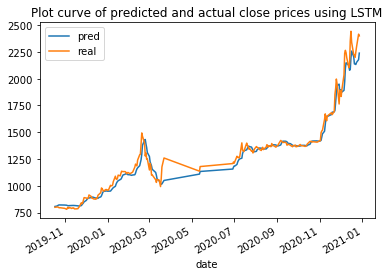

In [31]:
plot =pd.DataFrame()
plot["pred"]=list(map(float, pre_LSTM))
plot["real"]=list(map(float, Y_test_res_LSTM))
plot["date"]=X_test_split.index[:-steps]
plot.plot(kind="line", x="date", title="Plot curve of predicted and actual close prices using LSTM")
plt.show()

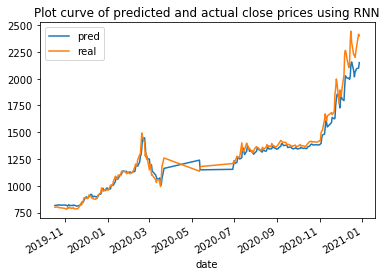

In [32]:
plot =pd.DataFrame()
plot["pred"]=list(map(float, pre_RNN))
plot["real"]=list(map(float, Y_test_res_RNN))
plot["date"]=X_test_split.index[:-steps]
plot.plot(kind="line", x="date", title="Plot curve of predicted and actual close prices using RNN")
plt.show()

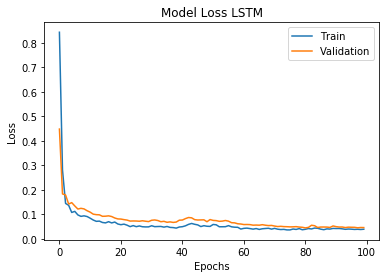

In [33]:
plt.plot(LSTM_History.history['loss'])
plt.plot(LSTM_History.history['val_loss'])
plt.title('Model Loss LSTM')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

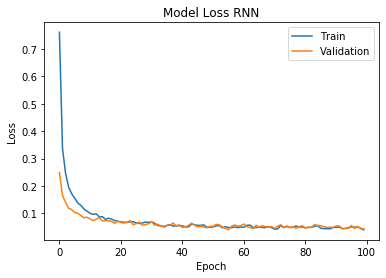

In [34]:
plt.plot(RNN_History.history['loss'])
plt.plot(RNN_History.history['val_loss'])
plt.title('Model Loss RNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

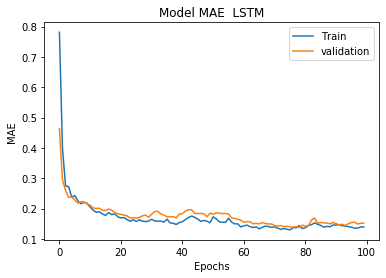

In [35]:
plt.plot(LSTM_History.history['mae'])
plt.plot(LSTM_History.history['val_mae'])
plt.title('Model MAE  LSTM')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend(['Train', 'validation'], loc='upper right')
plt.show()

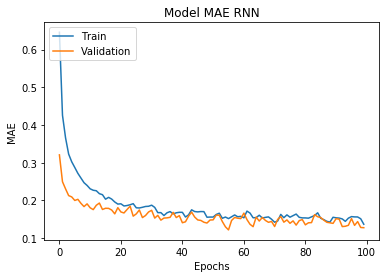

In [36]:
plt.plot(RNN_History.history['mae'])
plt.plot(RNN_History.history['val_mae'])
plt.title('Model MAE RNN')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Conclusion

1. For NLIC LSTM and RNN Models used for Stock Price Prediction
2. The Error is Low for LSTM Model